In [1]:
import sys

import pandas as pd
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import paleobeasts as pb
from paleobeasts.signal_models import ebm as pb_ebm
import paleobeasts.utils.utilities as pbu


In [2]:
T_init = [288]
length = 10000
t_i = 0
t_f = t_i+length
delta_t=.5

In [3]:
periods_powers = [(11, .40), (90, .80), (200, 1.15)]
forcing_func = pbu.create_periodic_forcing_function(periods_powers, desired_amplitude=3, y0=1360/4)


## 1. EBM with function as forcing

In [99]:
ebm_forcing = pb.Forcing(forcing_func)


In [100]:
ebm_rk45 = pb_ebm.EBM(forcing=ebm_forcing, albedo=pb_ebm.albedo_func)
ebm_rk45.integrate((t_i, t_f), T_init, method='RK45', kwargs={'max_step':.1})


In [101]:
for key in ebm_rk45.diagnostic_variables.keys():
    print(key, ebm_rk45.diagnostic_variables[key][-1])

albedo 0.3016158197035886
absorbed_SW 238.10188958499685
OLR 237.77264763559532
solar_incoming 340.93253584859343


## 2. EBM with data array as forcing (sampled function output)

In [102]:
integration_time = np.arange(t_i, t_f+100, 4)
ebm_forcing2 = pb.Forcing(forcing_func(integration_time), time=integration_time, interpolation='linear')

data is an array


In [103]:
ebm_rk45_2 = pb_ebm.EBM(forcing=ebm_forcing2, albedo=pb_ebm.albedo_func)
ebm_rk45_2.integrate((t_i, t_f), T_init, method='RK45', kwargs={'max_step':.1})


Text(0, 0.5, 'forcing')

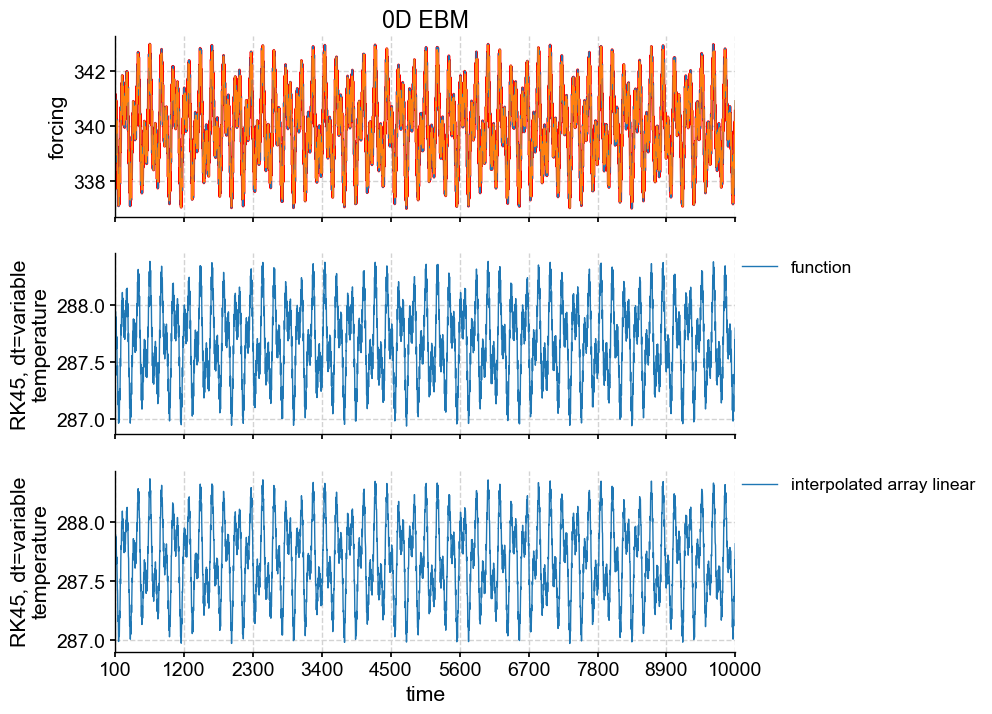

In [108]:
end_kya=t_f
plot_time_length = length-100
start_kya=end_kya-plot_time_length

model_sols = [ebm_rk45, ebm_rk45_2]

t_range = np.arange(start_kya, end_kya, 1)
ticks = np.linspace(start_kya, end_kya, 10)  # Generate 6 ticks from 800 to 3000
tick_labels = [str(int(tick)) for tick in ticks]  # Calculate labels 800 to 0

fig, ax = plt.subplots(len(model_sols)+1, 1, sharex=True, figsize=(8, 8))

for ik, model_sol in enumerate(model_sols):
    time = np.array(model_sol.time)#['t_arr']
    time_mask = time>=start_kya
    model_sol_y = model_sol.state_variables['T']
     
    model_forcing = model_sol.forcing.get_forcing(time[time_mask])
    label=model_sol.forcing.forcing_type#','.join([r'$v_c=$'+str(model_sol.model.vc)])
    ax[ik+1].plot(time[time_mask], model_sol_y[time_mask], linewidth=1,label=label) # marker='o', markersize=4, 
        
    ax[ik+1].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
    if ik ==0:
        ax[0].plot(t_range, model_sol.forcing.get_forcing(t_range), label='smooth', color='red')
    ax[0].plot(time[time_mask], model_forcing, linewidth=1, label=label)

    ax[ik+1].set_xticks(ticks)
    ax[ik+1].set_ylabel('\n'.join([model_sol.run_name,model_sol.variable_name]))
    ax[ik+1].set_xlim([start_kya, end_kya])
    
ax[-1].set_xticklabels(tick_labels)
ax[-1].set_xlabel('time')
ax[0].set_xlim([start_kya, end_kya])
ax[0].set_title('0D EBM')
ax[0].set_ylabel('forcing')

Text(0.5, 0, 'time')

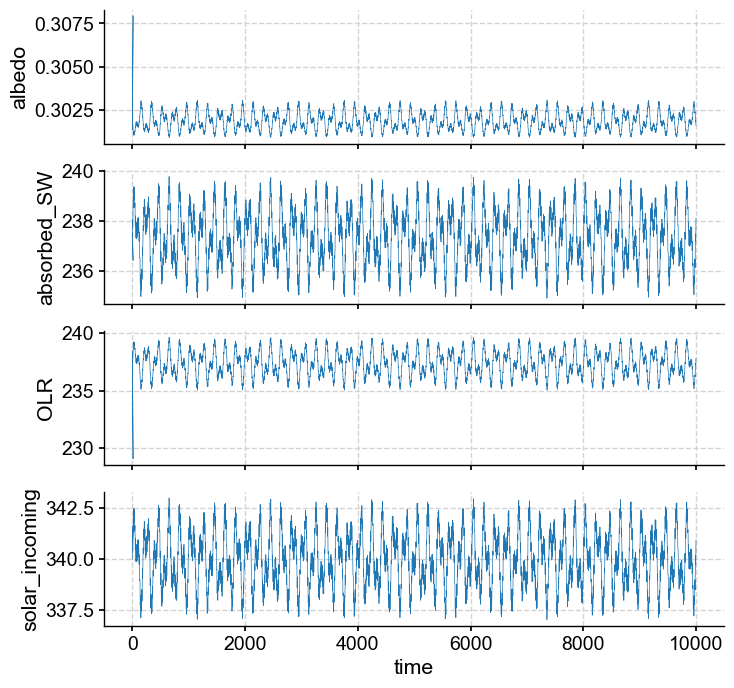

In [110]:
fig, ax = plt.subplots(len(ebm_rk45_2.diagnostic_variables), 1, sharex=True, figsize=(8, 8))
for ik, var in enumerate(ebm_rk45_2.diagnostic_variables.keys()):
    ax[ik].plot(ebm_rk45_2.time, ebm_rk45_2.diagnostic_variables[var], label=var, linewidth=.5)
    ax[ik].set_ylabel(var)
    
ax[-1].set_xlabel('time')


## 3. EBM with TSI (Vieira et al. 2011) as forcing

In [18]:
import os
from pathlib import Path
proj_dir = Path(os.getcwd()).parent

In [19]:
import pandas as pd
tsi_data = pd.read_csv(proj_dir/'data/vieira_tsi.csv')
years = [int(col) for col in tsi_data.columns if col.strip('-').isnumeric()==True]
year_cols = [col for col in tsi_data.columns if col.strip('-').isnumeric()==True]

tsi_array = tsi_data[year_cols].iloc[0].values

# tsi_data.columns[0].isnumeric(), tsi_data.columns[0]

In [20]:
tsi_time = np.array([yr+8045 for yr in years])

In [83]:
tsi_forcing = pb.Forcing(.25*(tsi_array+1360), time=tsi_time, interpolation='cubic')

data is an array


In [94]:
ebm_tsi_rk45 = pb_ebm.EBM(forcing=tsi_forcing, albedo=pb_ebm.albedo_func)
ebm_tsi_rk45.integrate((min(tsi_time), max(tsi_time)), T_init, method='RK45', kwargs=dict(max_step=1, atol=.1, rtol=.1))


In [95]:
ebm_tsi_euler = pb_ebm.EBM(forcing=tsi_forcing, albedo=pb_ebm.albedo_func)
ebm_tsi_euler.integrate((min(tsi_time), max(tsi_time)), T_init, method='euler', kwargs={'dt':5})
# for key in ebm_tsi_euler.diagnostic_variables.keys():
#     print(key, ebm_tsi_euler.diagnostic_variables[key][-1])
# ebm_tsi_euler.solution.y[-1]

In [96]:
ebm_tsi_euler_2 = pb_ebm.EBM(forcing=tsi_forcing, albedo=pb_ebm.albedo_func)
ebm_tsi_euler_2.integrate((min(tsi_time), max(tsi_time)), T_init, method='euler', kwargs={'dt':2})

Text(0, 0.5, 'forcing')

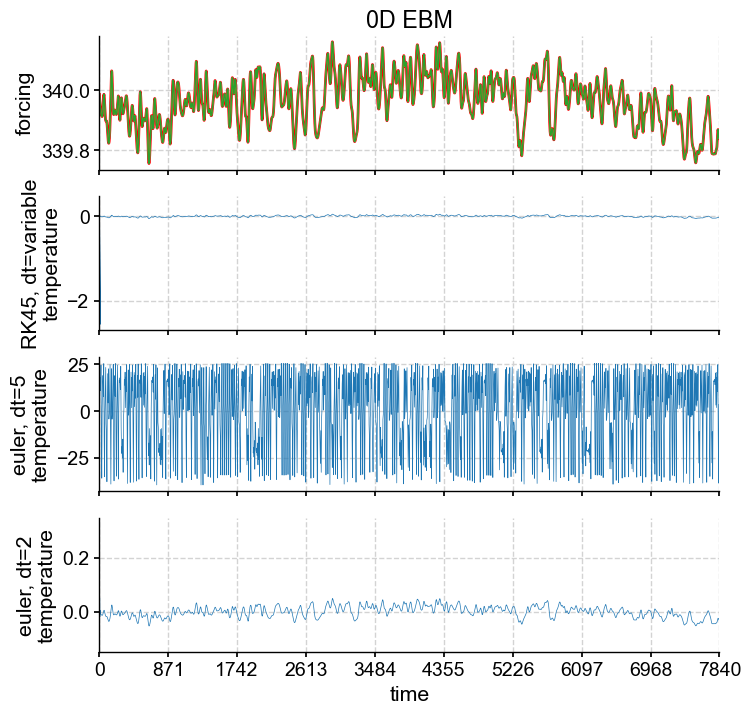

In [98]:
end_kya=max(tsi_time)
start_kya=min(tsi_time)

model_sols = [ebm_tsi_rk45, ebm_tsi_euler, ebm_tsi_euler_2]

t_range = np.arange(start_kya, end_kya, 1)
ticks = np.linspace(start_kya, end_kya, 10)  # Generate 6 ticks from 800 to 3000
tick_labels = [str(int(tick)) for tick in ticks]  # Calculate labels 800 to 0

fig, ax = plt.subplots(len(model_sols)+1, 1, sharex=True, figsize=(8, 8))

for ik, model_sol in enumerate(model_sols):
    time = model_sol.time#.t#['t_arr']
    time_mask = time>=start_kya
    model_sol_y = model_sol.state_variables['T']#'.y[:,0]
     
    model_forcing = model_sol.forcing.get_forcing(time[time_mask])
    label=None#','.join([r'$v_c=$'+str(model_sol.model.vc)])
    ax[ik+1].plot(time[time_mask], model_sol_y[time_mask]-np.mean(model_sol_y[time_mask]), linewidth=.5,label=label) # marker='o', markersize=4, 
        
    ax[ik+1].legend()
    if ik ==0:
        ax[0].plot(t_range, model_sol.forcing.get_forcing(t_range), label='smooth', color='red')
    ax[0].plot(time[time_mask], model_forcing, linewidth=1, label=label)
    ax[ik+1].set_xticks(ticks)
    ax[ik+1].set_ylabel('\n'.join([model_sol.run_name,model_sol.variable_name]))
    ax[ik+1].set_xlim([start_kya, end_kya])
    
ax[-1].set_xticklabels(tick_labels)
ax[-1].set_xlabel('time')
ax[0].set_xlim([start_kya, end_kya])
ax[0].set_title('0D EBM')
ax[0].set_ylabel('forcing')